In [12]:
%reload_ext autoreload
%autoreload 2

In [13]:
import fastai
from fastai.vision import *

In [14]:
from utils import FocalLoss
from imbalanced_sampler import ImbalancedDatasetSampler

In [15]:
path = Path('.')

In [16]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [17]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [18]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [19]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [20]:
(df.has_oilpalm==1).sum()

942

In [151]:
def get_data(df, size=128, bs=64, pct=0.2, seed=2019):
    data = (ImageItemList.from_df(df, path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names)
           .transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size))
            
    return data.databunch(bs=bs).normalize(imagenet_stats)

In [22]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, mixup=True, fp16=True):
    learn = create_cnn(data, 
                       models.resnet18,
                       pretrained=True,
                       ps=0,
                       loss_func=FocalLoss(gamma=2),
                       metrics=[accuracy])
    if mixup: learn.mixup()
    if fp16: return learn.to_fp16()
    else: return learn

In [23]:
data = get_data(df, 256, 64)

In [24]:
learn = get_learner(data, mixup=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 70079243.94it/s]


In [25]:
learn.loss_func

MixUpLoss(
  (crit): FocalLoss()
)

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02


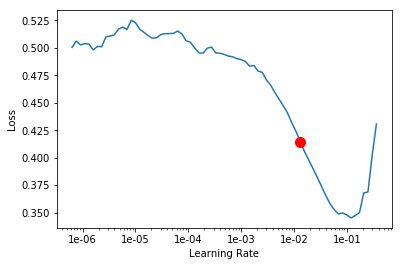

In [29]:
learn.lr_find(); learn.recorder.plot()

In [26]:
lr = 1e-2

256

In [27]:
learn.fit_one_cycle(6, lr)
learn.save('R18_256')

epoch,train_loss,valid_loss,accuracy
1,0.053104,0.024545,0.965223
2,0.044641,0.014664,0.986877
3,0.038752,0.026500,0.984908
4,0.032192,0.012697,0.987861
5,0.034197,0.018363,0.986549
6,0.032466,0.015127,0.989173


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


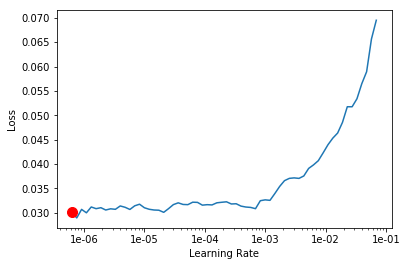

In [33]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [29]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-5,1e-3))
learn.save('R18_256u')

epoch,train_loss,valid_loss,accuracy
1,0.031787,0.017405,0.988189
2,0.032613,0.022597,0.982612
3,0.033542,0.011977,0.987533
4,0.032145,0.015240,0.989173
5,0.029220,0.013114,0.990157
6,0.028201,0.013795,0.988845


Results

[(1, 0, 26), (0, 1, 8)]

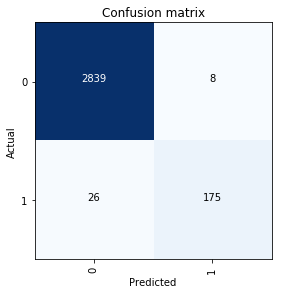

In [32]:
learn = get_learner(data, mixup=False)
learn.load('R18_256u');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()

In [155]:
def get_hard(learn):
    interp_val = ClassificationInterpretation.from_learner(learn)
    interp_train = ClassificationInterpretation.from_learner(learn, DatasetType.Train)
    fn, fp = interp_val.most_confused()
    n1 = fn[2]+fp[2]
    fn, fp = interp_train.most_confused()
    n2 = fn[2]+fp[2]
    print(f'Hard images count : {n1+n2}')
    losses, idxs_val = interp_val.top_losses(int(n1))
    losses, idxs_train = interp_train.top_losses(int(n2))

    hard_images_val = data.valid_ds.items[idxs_val]
    hard_images_train = data.train_ds.items[idxs_train]

    hard_images_names = [f[-17:] for f in hard_images_train] + [f[-17:] for f in hard_images_val]; hard_images_names[0:3]
    return hard_images_names

In [127]:
hard_images_names = get_hard(learn)

df2 = df.set_index('image_id')
df2 = df2.loc[hard_images_names]
df2.reset_index().to_csv('hard_examples.csv', index=False)

In [129]:
df2 = pd.read_csv('hard_examples.csv')

In [147]:
data = get_data(df2, 256, 8, 0.1)

In [148]:
learn = get_learner(data, mixup=False)

In [150]:
learn.load('256u');
learn.fit_one_cycle(10, slice(1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.830727,0.731791,0.714286
2,0.696769,0.998761,0.714286
3,0.703259,0.810313,0.714286
4,0.718831,0.863657,0.714286
5,0.751492,0.981853,0.714286
6,0.730802,0.960614,0.714286
7,0.748094,0.968285,0.714286
8,0.805078,1.015375,0.714286
9,0.744649,0.897016,0.714286
10,0.738353,0.849498,0.714286


In [151]:
learn.save('hard')

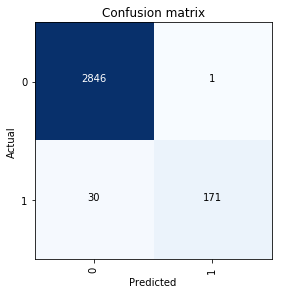

In [152]:
data = get_data(df, 256, 64)
learn = get_learner(data, mixup=False)
learn.load('hard')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Sub file

In [16]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [17]:
ids.shape

(6534,)

In [18]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)

In [19]:
sub.to_csv('sub_resnet18.csv', index=False)

In [24]:
sub.has_oilpalm.asdtype(float)

AttributeError: 'Series' object has no attribute 'asdtype'

# Metric Learning 

[(1, 0, 26), (0, 1, 8)]

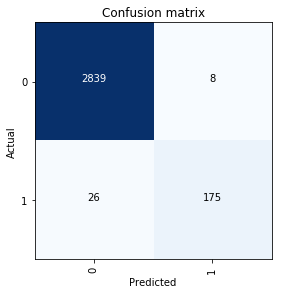

In [90]:
learn = get_learner(data, mixup=False)
learn.load('R18_256u');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()

In [149]:
def feature_map(data):
    learn = get_learner(data)
    learn.load('R18_256u');
    learn.model = nn.Sequential(*learn.model[0],*learn.model[1][0:2])
    p,t = learn.get_preds(DatasetType.Fix)
    p_t, t_t = learn.get_preds(DatasetType.Test)
    return p, t, p_t, t_t

In [152]:
data_no_valid = get_data(df, 256, 64, 0)

In [153]:
p,t, p_t, t_t = feature_map(data_no_valid )

In [159]:
N=len(df)
np.random.seed(2019)
val_idxs = np.random.permutation(range_of(range(N)))
cut = int(0.2 * N)

In [160]:
val_idxs[2032]

7822

In [161]:
len(p)==len(df)

True

In [162]:
def calculate_distance(x,y):
    d = (x-y)**2
    return d.sum(dim=1)

In [263]:
def compute_distances(p, p_t):
    sample = len(p_t)
    distances = torch.zeros(sample,len(p))
    for i in progress_bar(range(sample)):
        distances[i,:] = calculate_distance(p_t[i,:], p)
    return distances

Validate Methodology

In [254]:
interp.top_losses(34)

(tensor([1.3719, 1.1770, 1.0599, 1.0517, 0.9549, 0.9343, 0.8569, 0.7490, 0.6342,
         0.6141, 0.5595, 0.5039, 0.4561, 0.3748, 0.3688, 0.3629, 0.3463, 0.3270,
         0.3178, 0.3160, 0.2962, 0.2879, 0.2845, 0.2840, 0.2831, 0.2702, 0.2584,
         0.2545, 0.2243, 0.2178, 0.2163, 0.2073, 0.2041, 0.1949]),
 tensor([2032, 1184,  954, 1828, 2943,  605, 2176,  699, 2626,  962, 1146, 2824,
         2981,  233, 2911, 1030,  990, 2296,  523, 1598,  849,  407, 2210,  585,
          141, 2047,  269, 2464, 1736,  311, 1558,  442, 1981,  596]))

In [166]:
learn.model = nn.Sequential(*learn.model[0],*learn.model[1][0:2])

In [255]:
p,t = learn.get_preds(DatasetType.Fix)
p_v, t_v = learn.get_preds()

In [256]:
hard_example = p_v[2032]

In [257]:
d_hard = calculate_distance(hard_example, p)

In [258]:
d_hard.topk(5, largest=False)

(tensor([1234.0710, 1243.8756, 1250.2562, 1262.2490, 1279.2744]),
 tensor([ 4131,  4733, 11604,  1349,  5393]))

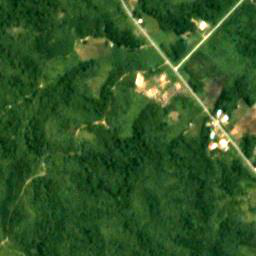

In [259]:
data.valid_ds[2032][0]

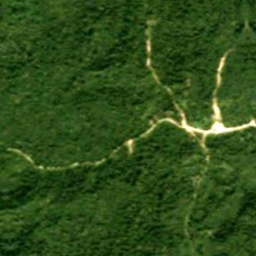

In [260]:
data.train_ds[4131][0]

In [ ]:
distances = compute_distances(p, p_v)

In [212]:
distances.shape

torch.Size([6534, 15244])

In [217]:
top5, idxs = distances.topk(5, dim=1, largest=False)

In [218]:
top5.shape

torch.Size([6534, 5])

In [219]:
idxs

tensor([[ 3777,  8382, 14145, 14040, 11855],
        [ 4467,  4640,  3822,  3900,  3837],
        [11776, 15094,  5729,  1974,  5779],
        ...,
        [12584, 11056, 12088,  3827, 13918],
        [  520,  5386,  1828,  1081, 12125],
        [ 7839, 10159,  8264,  4156, 12178]])

In [232]:
top5

tensor([[1704.1982, 1708.8862, 1726.6995, 1757.3429, 1786.5820],
        [ 781.8929,  784.1206, 1050.7411, 1082.5743, 1155.3534],
        [ 840.5803,  928.6921,  971.1619, 1000.5961, 1026.5088],
        ...,
        [ 316.3692,  333.5886,  338.5472,  339.5846,  351.2447],
        [ 922.8767,  992.3467, 1002.3398, 1114.6808, 1117.0786],
        [ 503.5440,  695.1309,  711.0129,  787.5848,  867.2104]])

In [237]:
averages = t[idxs].float().mean(dim=1)

In [239]:
th=200
idxs_ = idxs[top5<th]

In [243]:
rows = top5[:,0]<th

In [250]:
new_probs = t[idxs[top5[:,0]<th]].float().mean(dim=1)

In [251]:
rows

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)